<h1>Checking results for M1 data - 4 files</h1>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [143]:
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import display, HTML

In [4]:
from discretisation.preprocessing import FileLoader
from models import HyperPars as AlignmentHyperPars
from discretisation.adduct_cluster import AdductCluster, Peak
from shared_bin_matching import SharedBinMatching as Aligner
from ground_truth import GroundTruth

<h2>1. Precursor Clustering</h2>

Function to plot cluster size

In [5]:
def plot_cluster_size(acs):
    rows = []
    for f in range(len(acs)):
        ac = acs[f]
        for cluster in ac.clusters:
            rows.append((f, cluster.id, len(cluster.members)))
    df = pd.DataFrame(rows, columns=['fileID', 'clusterID', 'size'])
    plt.figure()
    sns.countplot(x='size', hue='fileID', data=df.sort_values(by=['size', 'fileID']))

In [6]:
def plot_biggest(acs, threshold, file_idx):

    ac = acs[file_idx]
    clusters_list = ac.clusters
    singleton_count = 0

    big_clusters = []
    biggest = clusters_list[0]
    for cluster in clusters_list:
        if cluster.N == 1:
            singleton_count += 1
        if cluster.N >= threshold:
            big_clusters.append(cluster)
            if cluster.N >= biggest.N:
                biggest = cluster

    print "Singleton count {}".format(singleton_count)
    print "{} big clusters found".format(len(big_clusters))
    print "Biggest has {} members".format(biggest.N)
    file_idx += 1

    for c in big_clusters:
        ac.cluster_plot(c)

Function to plot transformation type

In [7]:
def plot_trans(acs, exclude_MH=True, size=4, aspect=1):
    rows = []
    mh_count = 0
    non_mh_count = 0
    for f in range(len(acs)):
        ac = acs[f]
        for cluster in ac.clusters:
            for peak, poss in cluster.members:
                if poss.transformation.name == 'M+H':
                    mh_count += 1
                else:
                    non_mh_count += 1
                if not exclude_MH:
                    rows.append((cluster.id, peak.feature_id, peak.file_id, peak.mass, peak.rt, peak.intensity,
                                 poss.transformation.name, poss.transformed_mass, poss.prob))
                elif poss.transformation.name != 'M+H':
                    rows.append((cluster.id, peak.feature_id, peak.file_id, peak.mass, peak.rt, peak.intensity,
                                 poss.transformation.name, poss.transformed_mass, poss.prob))
                
    df = pd.DataFrame(rows, columns=["clusterID", "peakID", "fileID", "mass", "RT", "intensity", "trans_name", "trans_mass", "prob"])  

    # plot trans counts
    plt.figure()
    sns.factorplot(y='trans_name', hue='fileID', data=df.sort_values(by=['trans_name', 'fileID']), kind='count', size=size, aspect=aspect)

    # plot trans probabilities
    if exclude_MH:    
        plt.figure()
        sns.factorplot(y="trans_name", x="prob", hue="fileID", data=df.sort_values(by=['trans_name', 'fileID']), kind='box', size=size, aspect=aspect)

    # print the counts
    print "Total peaks having M+H trans = %d" % mh_count
    print "Total peaks having non-M+H trans = %d" % non_mh_count

<h3>a. Load data</h3>

For some reasons, it takes forever to run the precursor clustering in the notebook??! Here we load some pickled results that I ran outside the notebook.

In [8]:
aligner_40 = Aligner.resume_from('/home/joewandy/Project/documents/new_measure_experiment/precursor_M1/results_to_check/within_file_40.project')
aligner_40_with_fragments_c13 = Aligner.resume_from('/home/joewandy/Project/documents/new_measure_experiment/precursor_M1/results_to_check/within_file_40_full.project')

Project loaded from /home/joewandy/Project/documents/new_measure_experiment/precursor_M1/results_to_check/within_file_40.project time taken = 17.8905658722
Project loaded from /home/joewandy/Project/documents/new_measure_experiment/precursor_M1/results_to_check/within_file_40_full.project time taken = 26.3686738014


In [9]:
data_list = aligner_40.data_list
hp = aligner_40.hp
total_peaks = 0
for f in range(len(data_list)):
    data = data_list[f]
    count = len(data.features)
    print "%d peaks in file %d" % (count, f)
    total_peaks += count
print "total peaks %d" % total_peaks

5843 peaks in file 0
7516 peaks in file 1
9133 peaks in file 2
5877 peaks in file 3
total peaks 28369


<h3>a. Check clusters</h3>

At this point, we have performed MAP assignment of peaks into their most likely precursor clusters. From inspection of the ground truth, we know that the value of *across_file_mass_tol* used for matching peaks in the ground truth is in the ballpark of 30-60 ppm. e.g. the following are two peaksets in ground truth:
<pre>
    (fileID, mass, rt, intensity)
    (0, 133.0316, 226.02, 1479)
    (1, 133.0371, 226.02, 2692)
    (2, 133.0342, 228, 2561)
    (4, 133.034, 222, 1495)

    (fileID, mass, rt, intensity)
    (0, 365.1094, 1377.96, 428)
    (1, 365.1107, 1377.96, 928)
    (2, 365.0899, 1377.96, 652)
    (3, 365.1154, 1375.98, 637)
</pre>

In [10]:
def mass_match(mass, other_masses, tol):
    return np.abs((mass-other_masses)/mass)<tol*1e-6

print mass_match(133.0316, 133.0371, 50)
print mass_match(133.0316, 133.0342, 30)
print mass_match(365.1094, 365.1107, 30)
print mass_match(365.1094, 365.0899, 60)

True
True
True
True


We don't know the best mass tolerance value within a file, so for now, we assume it's the same as the across-file value and set it to 40 ppm in our experiments. Below are some results at *within_file_mass_tol*=40 ppm, *within_file_rt_tol*=5.

Using the original list of common adducts in positive mode.

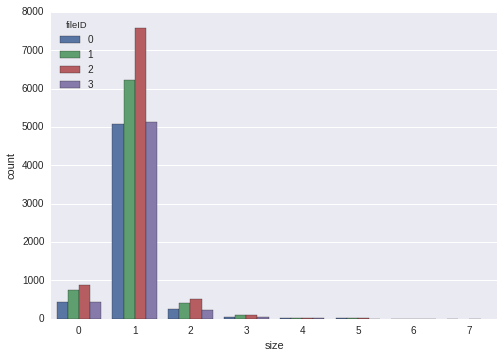

In [11]:
plot_cluster_size(aligner_40.clustering_results)

Looking at the biggest cluster in each file, we see that it's generally preserved?

Singleton count 5079
1 big clusters found
Biggest has 7 members
CLUSTER 1157
Peak: 236.522691,222.0 -> M+2H,471.030829096 (p=0.914642562237)
Peak: 258.506787,222.0 -> M+2Na,471.03513184 (p=0.806397154669)
Peak: 535.056214,222.0 -> M+ACN+Na,471.040443818 (p=0.635380075335)
Peak: 489.07495,223.98 -> M+NH4,471.041124446 (p=0.573458878561)
Peak: 472.040763,222.0 -> M+H,471.033486548 (p=1.0)
Peak: 550.052825,222.0 -> M+DMSO+H,471.031613004 (p=0.833917494172)
Peak: 504.065821,220.02 -> M+CH3OH+H,471.032329798 (p=0.508146150158)


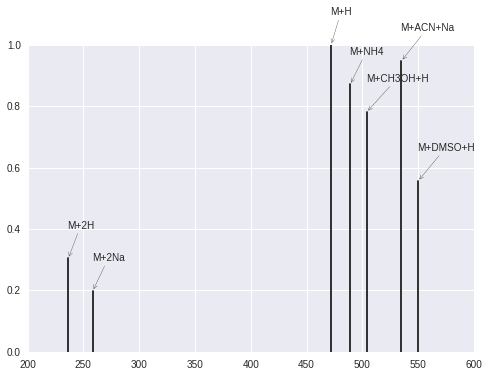

In [12]:
plot_biggest(aligner_40.clustering_results, 7, 0)

Singleton count 6214
1 big clusters found
Biggest has 6 members
CLUSTER 1208
Peak: 267.942285,190.02 -> M+H+NH4,516.843467994 (p=0.997790685842)
Peak: 534.872031,192.0 -> M+NH4,516.838205446 (p=0.95650671792)
Peak: 558.869438,190.02 -> M+ACN+H,516.835612446 (p=0.812901755374)
Peak: 517.855183,190.02 -> M+H,516.847906548 (p=0.879699510639)
Peak: 549.870767,192.0 -> M+CH3OH+H,516.837275798 (p=0.961753535541)
Peak: 595.863662,190.02 -> M+DMSO+H,516.842450004 (p=0.771723413518)


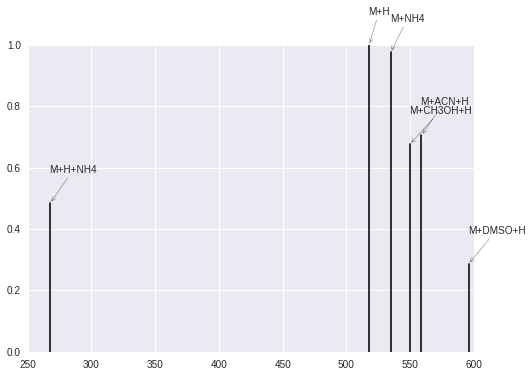

In [13]:
plot_biggest(aligner_40.clustering_results, 6, 1)

Singleton count 7593
1 big clusters found
Biggest has 7 members
CLUSTER 2753
Peak: 254.546055,223.98 -> M+ACN+2H,466.051007994 (p=0.985702682294)
Peak: 484.091322,223.98 -> M+NH4,466.057496446 (p=0.999980142965)
Peak: 545.065371,222.0 -> M+DMSO+H,466.044159004 (p=0.970281761992)
Peak: 499.096614,223.98 -> M+CH3OH+H,466.063122798 (p=0.994850432708)
Peak: 508.078325,223.98 -> M+ACN+H,466.044499446 (p=0.96265738162)
Peak: 489.051117,220.02 -> M+Na,466.06189592 (p=0.989953586075)
Peak: 467.059624,220.02 -> M+H,466.052347548 (p=0.882866570005)


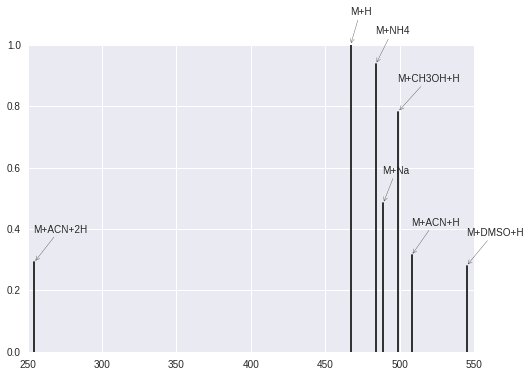

In [14]:
plot_biggest(aligner_40.clustering_results, 7, 2)

Singleton count 5134
2 big clusters found
Biggest has 6 members
CLUSTER 783
Peak: 259.031411,216.0 -> M+ACN+2H,475.021719994 (p=0.999952149072)
Peak: 476.028271,217.98 -> M+H,475.020994548 (p=1.0)
Peak: 517.044599,216.0 -> M+ACN+H,475.010773446 (p=0.572623262029)
Peak: 498.022124,216.0 -> M+Na,475.03290292 (p=0.999750261896)
Peak: 493.051028,220.02 -> M+NH4,475.017202446 (p=0.999886634629)
Peak: 554.042329,217.98 -> M+DMSO+H,475.021117004 (p=0.850688257211)
CLUSTER 956
Peak: 254.537851,222.0 -> M+H+NH4,490.034599994 (p=0.999914190296)
Peak: 491.034692,220.02 -> M+H,490.027415548 (p=0.96925075564)
Peak: 523.065663,220.02 -> M+CH3OH+H,490.032171798 (p=0.991793602691)
Peak: 569.053261,220.02 -> M+DMSO+H,490.032049004 (p=0.999982168669)
Peak: 508.079866,220.02 -> M+NH4,490.046040446 (p=0.746902135375)
Peak: 573.102562,222.0 -> M+2ACN+H,490.042187345 (p=0.999941292791)


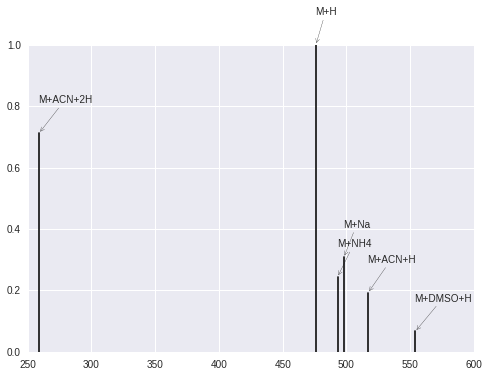

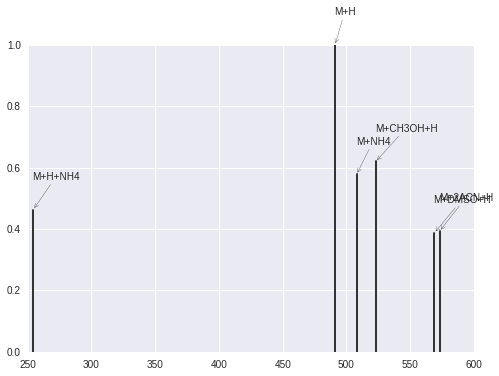

In [15]:
plot_biggest(aligner_40.clustering_results, 6, 3)

We get even more big clusters when using the expanded transformation list with fragments & isotope (C13).

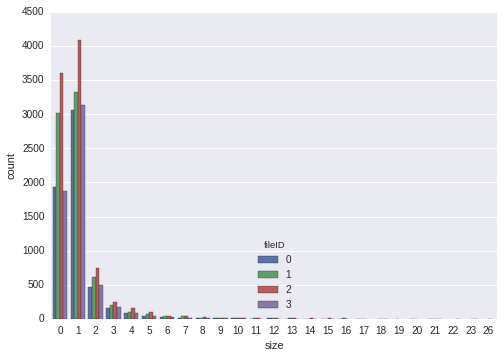

In [16]:
plot_cluster_size(aligner_40_with_fragments_c13.clustering_results)

Singleton count 3057
2 big clusters found
Biggest has 21 members
CLUSTER 1018
Peak: 236.522691,222.0 -> [M-H2O]+2H,489.041393782 (p=0.481507119931)
Peak: 233.51469,222.0 -> [M-CH2O2]+H+Na,489.038361776 (p=0.875091579193)
Peak: 234.520309,220.02 -> [M-CO2]+H+Na,489.033949712 (p=0.887669316905)
Peak: 257.536363,223.98 -> [M-H2O]+ACN+2H [C13],489.038833843 (p=0.616471569711)
Peak: 258.506787,222.0 -> [M-H2O]+2Na,489.045696526 (p=0.582444459677)
Peak: 485.073742,222.0 -> [M-CH2O2]+ACN+H,489.045395755 (p=0.746211123546)
Peak: 491.051389,220.02 -> M+H [C13],489.04075771 (p=0.454415623442)
Peak: 490.054217,222.0 -> M+H,489.046940548 (p=0.634280860908)
Peak: 524.065101,222.0 -> [M-CO2]+DMSO+H,489.033718249 (p=0.324641506513)
Peak: 535.056214,222.0 -> [M-H2O]+ACN+Na,489.051008505 (p=0.341520052566)
Peak: 447.058533,222.0 -> [M-CO2]+H [C13],489.037730954 (p=0.383831664047)
Peak: 489.07495,223.98 -> [M-H2O]+NH4,489.051689132 (p=0.330643220398)
Peak: 472.040763,222.0 -> [M-H2O]+H,489.044051234 (p=

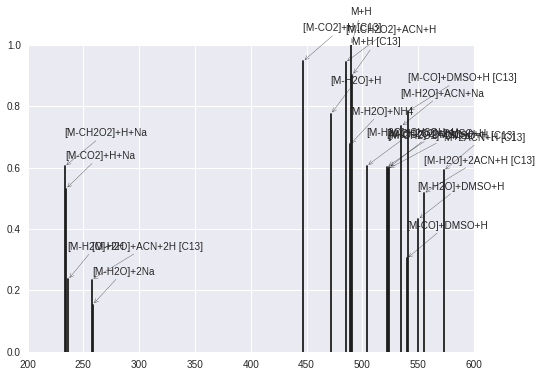

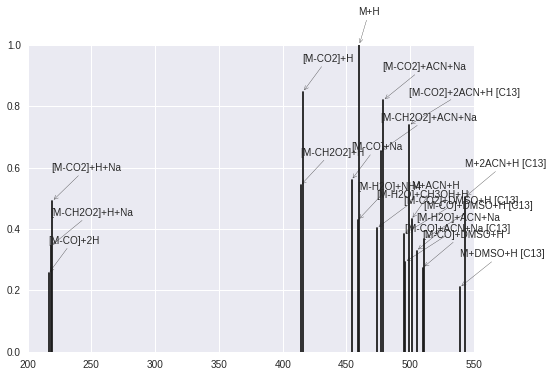

In [17]:
plot_biggest(aligner_40_with_fragments_c13.clustering_results, 20, 0)

Singleton count 3330
2 big clusters found
Biggest has 21 members
CLUSTER 1208
Peak: 553.854858,190.02 -> [M-CO]+ACN+Na [C13],516.830647603 (p=0.424699440211)
Peak: 267.942285,190.02 -> M+H+NH4,516.843467994 (p=0.611493129476)
Peak: 489.871571,190.02 -> [M-CH2O2]+NH4 [C13],516.839869917 (p=0.58748141447)
Peak: 512.861739,190.02 -> [M-CH2O2]+ACN+H,516.833392755 (p=0.7091400203)
Peak: 531.861509,192.0 -> [M-H2O]+CH3OH+H,516.838582484 (p=0.960243465032)
Peak: 532.858983,192.0 -> [M-H2O]+CH3OH+H [C13],516.832701647 (p=0.500925010333)
Peak: 534.872031,192.0 -> M+NH4,516.838205446 (p=0.441649645762)
Peak: 537.862463,190.02 -> [M-CO2]+ACN+Na [C13],516.833167225 (p=0.428131456432)
Peak: 541.857686,190.02 -> [M-H2O]+ACN+H [C13],516.831070295 (p=0.454864354061)
Peak: 558.869438,190.02 -> M+ACN+H,516.835612446 (p=0.454838137647)
Peak: 513.873034,192.0 -> [M-CH2O2]+ACN+H [C13],516.841332917 (p=0.469318496372)
Peak: 536.866151,192.0 -> [M-CO2]+ACN+Na,516.840210062 (p=0.596370930345)
Peak: 540.862903

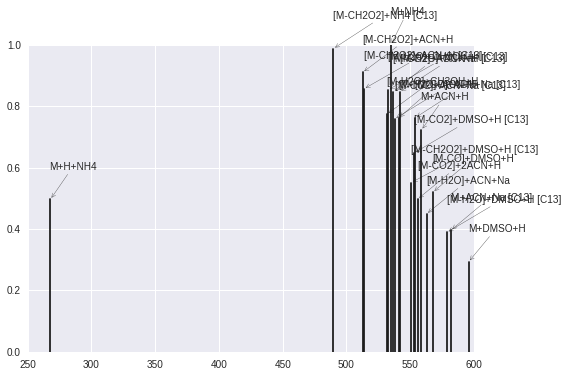

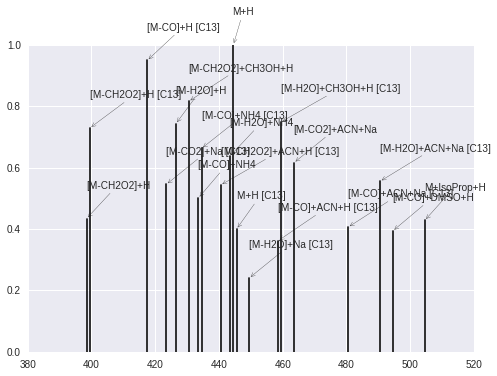

In [18]:
plot_biggest(aligner_40_with_fragments_c13.clustering_results, 20, 1)

Singleton count 4082
3 big clusters found
Biggest has 26 members
CLUSTER 873
Peak: 265.946563,187.98 -> [M-CO]+ACN+2H [C13],515.843583779 (p=0.452806759398)
Peak: 502.866616,187.98 -> [M-CH2O2]+CH3OH+H,515.838604107 (p=0.961118548216)
Peak: 520.869807,190.02 -> [M-CO]+CH3OH+H,515.83123042 (p=0.602219055455)
Peak: 521.869838,192.0 -> [M-CO]+CH3OH+H [C13],515.827906582 (p=0.579119955264)
Peak: 534.878384,190.02 -> M+NH4 [C13],515.841203608 (p=0.517494351752)
Peak: 503.859447,190.02 -> [M-CH2O2]+CH3OH+H [C13],515.828080269 (p=0.683355387134)
Peak: 511.857706,190.02 -> [M-CH2O2]+ACN+H,515.829359755 (p=0.997517431136)
Peak: 512.875879,192.0 -> [M-CH2O2]+ACN+H [C13],515.844177917 (p=0.317474258337)
Peak: 513.874144,192.0 -> [M-CO2]+ACN+H,515.830147691 (p=0.64090990892)
Peak: 516.850628,190.02 -> M+H,515.843351548 (p=0.999999961772)
Peak: 530.847807,190.02 -> [M-H2O]+CH3OH+H,515.824880484 (p=0.892609369639)
Peak: 531.855684,192.0 -> [M-H2O]+CH3OH+H [C13],515.829402647 (p=0.757982926754)
Peak:

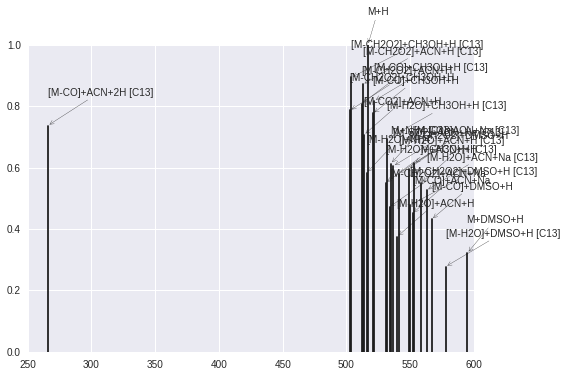

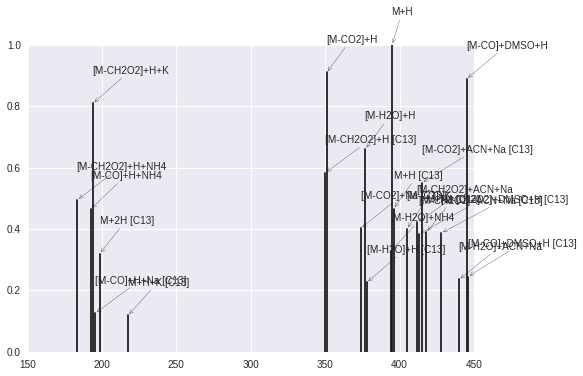

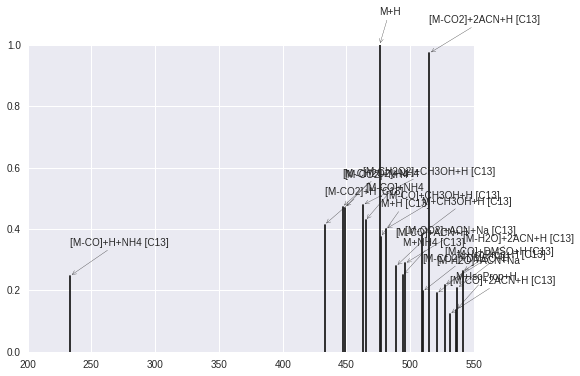

In [19]:
plot_biggest(aligner_40_with_fragments_c13.clustering_results, 20, 2)

Singleton count 3134
3 big clusters found
Biggest has 23 members
CLUSTER 783
Peak: 238.499088,217.98 -> [M-CO2]+2Na,475.009563084 (p=0.842040520717)
Peak: 447.046188,220.02 -> [M-CH2O2]+NH4,475.017841755 (p=0.501989318182)
Peak: 476.028271,217.98 -> M+H,475.020994548 (p=1.0)
Peak: 449.048769,220.02 -> [M-CO2]+NH4,475.00477269 (p=0.603114808279)
Peak: 496.035012,217.98 -> [M-CO2]+ACN+Na [C13],475.005716225 (p=0.907725338497)
Peak: 515.092516,220.02 -> [M-CO2]+2ACN+H [C13],475.018615751 (p=0.999991818449)
Peak: 517.044599,216.0 -> M+ACN+H,475.010773446 (p=0.775049180331)
Peak: 463.035713,217.98 -> [M-CH2O2]+CH3OH+H [C13],475.004346269 (p=0.957249837987)
Peak: 465.045329,217.98 -> [M-CO]+NH4,475.006418068 (p=0.990096352347)
Peak: 473.061,220.02 -> [M-CO2]+ACN+H,475.017003691 (p=0.385600868229)
Peak: 475.037377,217.98 -> [M-H2O]+NH4,475.014116132 (p=0.957264976549)
Peak: 494.024522,220.02 -> [M-CH2O2]+ACN+Na [C13],475.010876289 (p=0.456610442742)
Peak: 541.065332,220.02 -> [M-H2O]+2ACN+H [

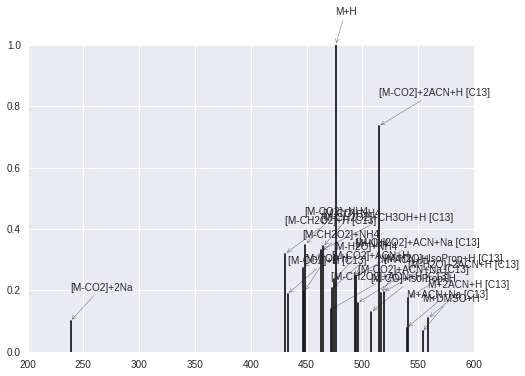

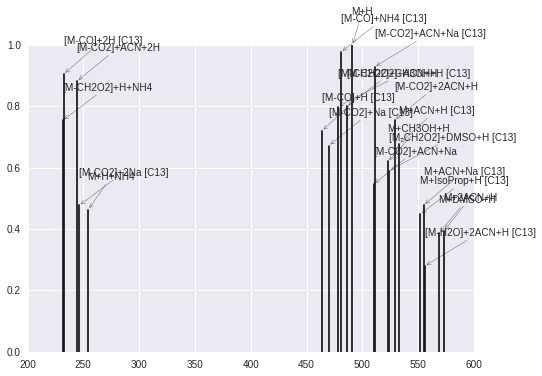

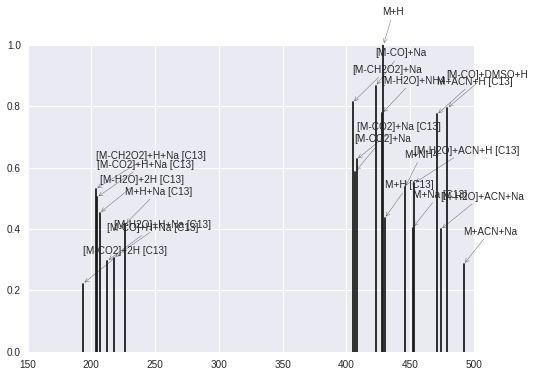

In [20]:
plot_biggest(aligner_40_with_fragments_c13.clustering_results, 20, 3)

<h3>b. Check transformations</h3>

Total peaks having M+H trans = 25828
Total peaks having non-M+H trans = 2541


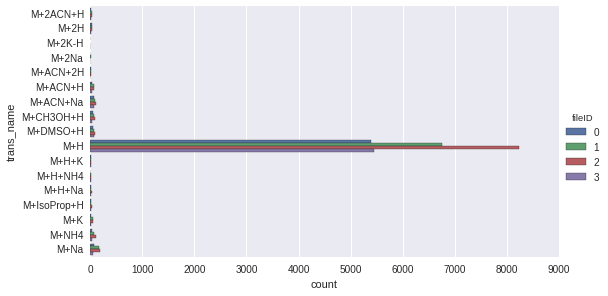

In [21]:
plot_trans(aligner_40.clustering_results, exclude_MH=False, aspect=2)

Total peaks having M+H trans = 17521
Total peaks having non-M+H trans = 10848


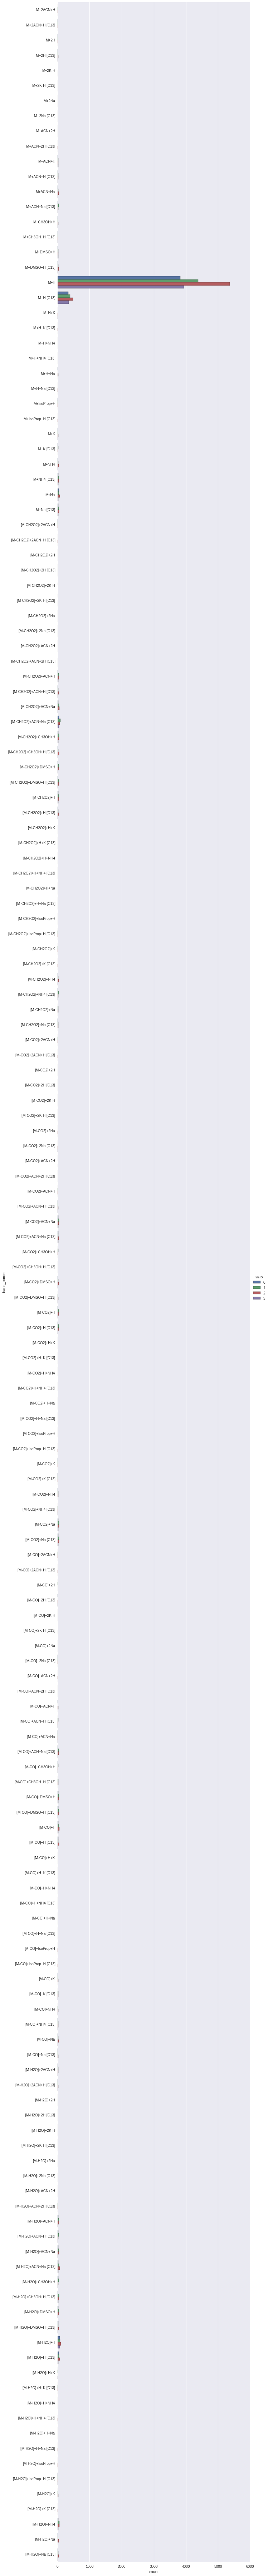

In [22]:
plot_trans(aligner_40_with_fragments_c13.clustering_results, exclude_MH=False, size=100, aspect=0.1)

In both cases, the M+H and M+H[C13] dominate the counts. If we exclude these two from the plots ...

Total peaks having M+H trans = 25828
Total peaks having non-M+H trans = 2541


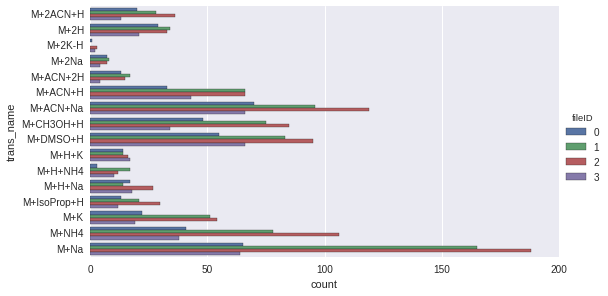

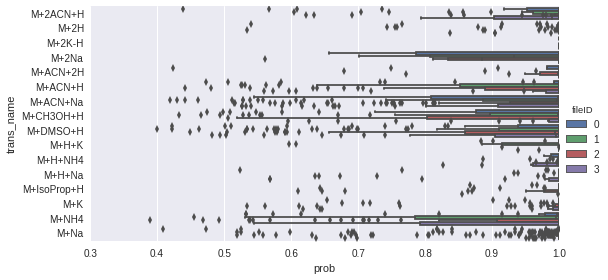

In [23]:
plot_trans(aligner_40.clustering_results, exclude_MH=True, aspect=2)

Total peaks having M+H trans = 17521
Total peaks having non-M+H trans = 10848


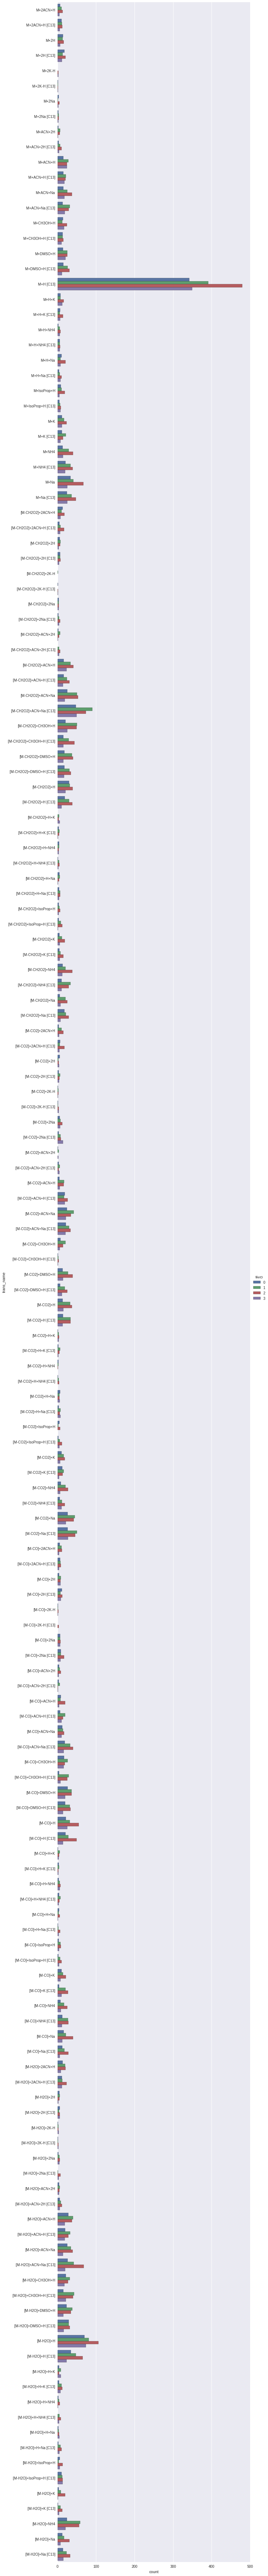

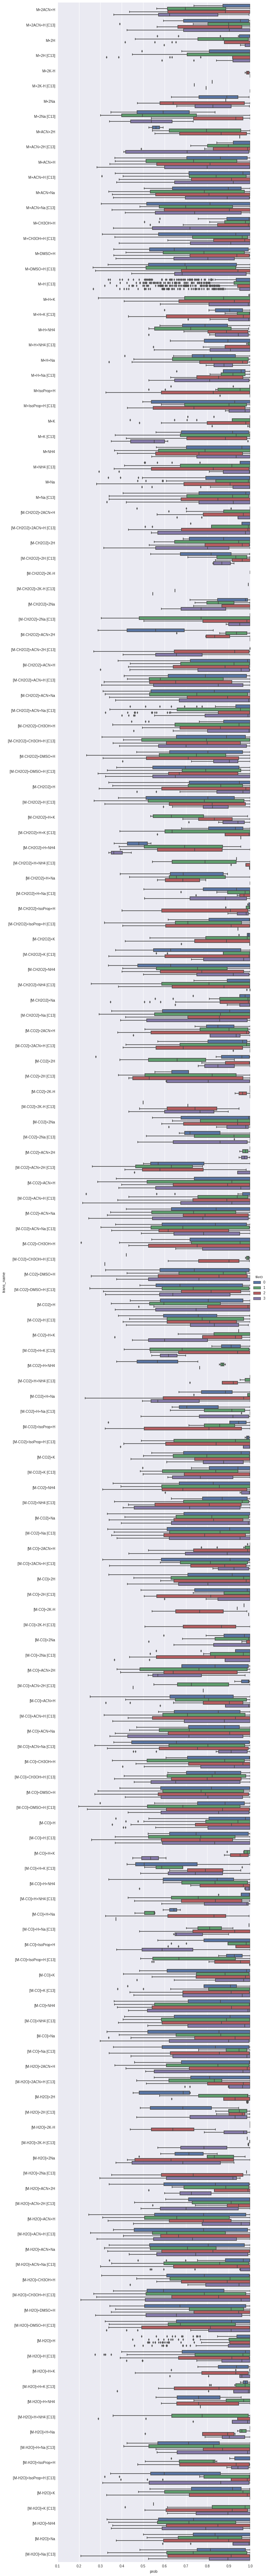

In [24]:
plot_trans(aligner_40_with_fragments_c13.clustering_results, exclude_MH=True, size=100, aspect=0.1)

<hr/>

<h2>2. Matching the Precursor Clusters</h2>

The next thing we can do is to take the list of non-empty precursor clusters from each file and merge-match them across files to construct the alignment. 

In [25]:
aligned_peaksets = []
i = 0
for i in range(len(aligner_40.alignment_results)):
    peakset = aligner_40.alignment_results[i].peakset
    aligned_peaksets.append(peakset)

In [26]:
print len(aligned_peaksets)

14559


Compare against the ground truth

In [27]:
file_list = aligner_40.file_list
gt_file = '/home/joewandy/git/metabolomics_tools/alignment/input/M1_4/ground_truth/ground_truth.txt'
gt = GroundTruth(gt_file, file_list, data_list)

Loaded 1007 ground truth entries


In [28]:
def get_aligned_peaksets(aligner, threshold):
    aligned_peaksets = []
    for i in range(len(aligner.alignment_results)):
        peakset = aligner.alignment_results[i].peakset
        prob = aligner.alignment_results[i].prob
        if len(peakset) >= threshold:
            aligned_peaksets.append((peakset, prob))
    return aligned_peaksets

In [29]:
def find_overlap(gt_entry, aligned_peaksets):
    overlap = []
    for ps, prob in aligned_peaksets:
        ps_keys = [f._get_key() for f in ps]
        any_found = False
        for f in gt_entry:
            if f._get_key() in ps_keys:
                any_found = True
        if any_found:
            overlap.append((ps, prob))
    return overlap

In [82]:
def print_peakset(peakset, prob, gt_entry, aligner, feature_binning=None, verbose=True):
    if verbose:
        print "  Peakset %.2f" % prob
    features = list(peakset)
    features.sort(key=lambda x: x.file_id)    
    gt_keys = [g._get_key() for g in gt_entry]
    match = True
    isMH = False
    for f in features:
        key = f._get_key()
        if feature_binning is not None:
            fbin = feature_binning[f._get_key()]
            annot = aligner.annotations[key] + " top_bin " + str(fbin)
        else:
            annot = aligner.annotations[key]            
        if 'M+H' in annot:
            isMH = True
        if verbose:
            print "  - id %s mass %.4f rt %.2f MAP_trans %s" % ((key, f.mass, f.rt, annot))    
        if key not in gt_keys:
            match = False
    if match:
        match_str = 'TRUE'
    else:
        match_str = 'FALSE'
    if verbose:
        print "  - Match=%s" % match_str
        print
    return match, isMH

In [85]:
def check_ground_truth(i, gt, aligned_peaksets, aligner, feature_binning, verbose=True):
    
    group = gt.gt_features[i]
    if verbose:
        print "Checking ground truth entry %d" % i
        for f in group:
            key = f._get_key()
            print "- id %s mass %.4f rt %.2f" % ((key, f.mass, f.rt))

    if verbose:
        print "Overlapping peaksets:"
        print
    overlap = find_overlap(group, aligned_peaksets)
    match = False
    isMH = False
    for ps, prob in overlap:
        match, isMH = print_peakset(ps, prob, group, aligner, feature_binning, verbose)
    return match, isMH

In [44]:
def print_peak_transformations(aligner, to_find, plot_cluster=False):
    ac = aligner.clustering_results[to_find[1]]
    for peak in ac.todo:
        if peak._get_key() == to_find:
            print "Possible clusters of peak %s" % peak
            for poss in ac.possible[peak]:
                cluster = poss.cluster
                print "- Cluster %d: %f (%s @ mz %.4f rt %.2f), prob = %.2f" % (cluster.id, cluster.M,
                    poss.transformation.name, poss.transformed_mass, poss.rt, poss.prob)
            if plot_cluster:
                print
                for poss in ac.possible[peak]:
                    cluster = poss.cluster
                    ac.cluster_plot(cluster)
                    print
            print

<h2>2a. Results using the list of common adducts</h2>

We enumerate all aligned peaksets of size 4 and compare them against ground truth.

True positives = items in ground truth and also in aligned peaksets of size 4

False positives = items in ground truth but not in aligned peaksets of size 4

In [86]:
min_size = 4
peaksets = get_aligned_peaksets(aligner_40, min_size) # peaksets of size 4 only
tp = [] # at least there are some matches in the aligned peakset
isMHs = [] # M+H?
fp = []
for i in range(len(gt.gt_features)):
    if len(gt.gt_features[i]) < min_size: # groundtruth of size 4 only
        continue
    match, isMH = check_ground_truth(i, gt, peaksets, aligner_40, None, verbose=False)
    if match:
        tp.append(i)
        isMHs.append(isMH)
    else:
        fp.append(i)

print "True positives = %d" % len(tp)
print "False positives = %d" % len(fp)

True positives = 538
False positives = 52


<h4>What we got right</h4>

Nearly everything that we got right are the M+H clusters, with a few exceptions.

In [93]:
# check the transformation type
mh_list = []
non_mh_list = []
for i,mh in zip(tp, isMHs):
    if mh:
        mh_list.append(i)
    else:
        non_mh_list.append(i)

In [94]:
print mh_list

[0, 1, 3, 4, 6, 7, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 39, 41, 44, 46, 47, 48, 49, 50, 52, 53, 54, 55, 57, 60, 61, 62, 64, 65, 66, 68, 71, 72, 73, 74, 75, 76, 104, 105, 106, 107, 108, 111, 112, 113, 114, 119, 121, 131, 132, 133, 137, 138, 139, 140, 141, 142, 143, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 193, 194, 197, 198, 199, 200, 203, 204, 205, 206, 210, 211, 212, 213, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 247, 248, 252, 253, 257, 258, 259, 261, 262, 263, 268, 269, 270, 271, 272, 273, 275, 276, 279, 282, 283, 284, 285, 286, 293, 294, 295, 296, 299, 300, 305, 306, 307, 308, 309, 310, 311, 312, 313, 315, 316, 317, 329, 330, 331, 332, 333, 340, 341, 342, 345, 346, 354, 355, 366, 367, 368, 369, 370, 374, 

In [108]:
print non_mh_list

[185, 314, 380, 382, 420, 508, 548, 594, 602, 605, 732, 763, 814]


In [105]:
peaksets = get_aligned_peaksets(aligner_40, 1)
for i in non_mh_list:
    check_ground_truth(i, gt, peaksets, aligner_40, None)

Checking ground truth entry 185
- id (2077, 0) mass 294.0134 rt 1151.94
- id (3550, 1) mass 294.0145 rt 1151.94
- id (4257, 2) mass 294.0142 rt 1151.94
- id (2095, 3) mass 294.0131 rt 1151.94
Overlapping peaksets:

  Peakset 1.00
  - id (2077, 0) mass 294.0134 rt 1151.94 MAP_trans M+DMSO+H@214.99101(1.0000)
  - id (3550, 1) mass 294.0145 rt 1151.94 MAP_trans M+DMSO+H@214.99499(1.0000)
  - id (4257, 2) mass 294.0142 rt 1151.94 MAP_trans M+DMSO+H@214.99295(1.0000)
  - id (2095, 3) mass 294.0131 rt 1151.94 MAP_trans M+DMSO+H@214.99369(0.9999)
  - Match=TRUE

Checking ground truth entry 314
- id (2158, 0) mass 617.1694 rt 1139.94
- id (3637, 1) mass 617.1721 rt 1139.94
- id (4409, 2) mass 617.1708 rt 1141.98
- id (2140, 3) mass 617.1789 rt 1141.98
Overlapping peaksets:

  Peakset 1.00
  - id (2158, 0) mass 617.1694 rt 1139.94 MAP_trans M+Na@594.18024(1.0000)
  - id (3637, 1) mass 617.1721 rt 1139.94 MAP_trans M+Na@594.17634(1.0000)
  - id (4409, 2) mass 617.1708 rt 1141.98 MAP_trans M+Na@5

Picking some examples, we see that we get it right when for each peak, the possible transformations are at most 2.

In [98]:
peaksets = get_aligned_peaksets(aligner_40, 1)
check_ground_truth(314, gt, peaksets, aligner_40, None)
print_peak_transformations(aligner_40, (2158, 0))
print_peak_transformations(aligner_40, (3637, 1))
print_peak_transformations(aligner_40, (4409, 2))
print_peak_transformations(aligner_40, (2140, 3))

Checking ground truth entry 314
- id (2158, 0) mass 617.1694 rt 1139.94
- id (3637, 1) mass 617.1721 rt 1139.94
- id (4409, 2) mass 617.1708 rt 1141.98
- id (2140, 3) mass 617.1789 rt 1141.98
Overlapping peaksets:

  Peakset 1.00
  - id (2158, 0) mass 617.1694 rt 1139.94 MAP_trans M+Na@594.18024(1.0000)
  - id (3637, 1) mass 617.1721 rt 1139.94 MAP_trans M+Na@594.17634(1.0000)
  - id (4409, 2) mass 617.1708 rt 1141.98 MAP_trans M+Na@594.17927(1.0000)
  - id (2140, 3) mass 617.1789 rt 1141.98 MAP_trans M+Na@594.18652(1.0000)
  - Match=TRUE

Possible clusters of peak id=(2158,0) mass=617.1694 rt=1139.94 int=2925.00
- Cluster 2157: 616.162156 (M+H @ mz 616.1622 rt 1139.94), prob = 0.00
- Cluster 2146: 594.183570 (M+Na @ mz 594.1802 rt 1139.94), prob = 1.00

Possible clusters of peak id=(3637,1) mass=617.1721 rt=1139.94 int=3238.00
- Cluster 3636: 616.164777 (M+H @ mz 616.1648 rt 1139.94), prob = 0.00
- Cluster 3547: 594.182122 (M+Na @ mz 594.1828 rt 1139.94), prob = 1.00

Possible cluster

In [101]:
peaksets = get_aligned_peaksets(aligner_40, 1)
check_ground_truth(380, gt, peaksets, aligner_40, None)
print_peak_transformations(aligner_40, (2621, 0))
print_peak_transformations(aligner_40, (4026, 1))
print_peak_transformations(aligner_40, (4983, 2))
print_peak_transformations(aligner_40, (2591, 3))

Checking ground truth entry 380
- id (2621, 0) mass 214.0408 rt 1345.98
- id (4026, 1) mass 214.0414 rt 1345.98
- id (4983, 2) mass 214.0422 rt 1347.96
- id (2591, 3) mass 214.0418 rt 1345.98
Overlapping peaksets:

  Peakset 1.00
  - id (2621, 0) mass 214.0408 rt 1345.98 MAP_trans M+Na@191.05038(0.9999)
  - id (4026, 1) mass 214.0414 rt 1345.98 MAP_trans M+Na@191.05044(0.9999)
  - id (4983, 2) mass 214.0422 rt 1347.96 MAP_trans M+Na@191.05068(0.9999)
  - id (2591, 3) mass 214.0418 rt 1345.98 MAP_trans M+Na@191.05112(0.9999)
  - Match=TRUE

Possible clusters of peak id=(2621,0) mass=214.0408 rt=1345.98 int=7548.00
- Cluster 2620: 213.033540 (M+H @ mz 213.0335 rt 1345.98), prob = 0.00
- Cluster 2638: 191.049773 (M+Na @ mz 191.0516 rt 1345.98), prob = 1.00

Possible clusters of peak id=(4026,1) mass=214.0414 rt=1345.98 int=8785.00
- Cluster 4025: 213.034084 (M+H @ mz 213.0341 rt 1345.98), prob = 0.00
- Cluster 4011: 191.049598 (M+Na @ mz 191.0521 rt 1345.98), prob = 1.00

Possible cluster

<h4>What we got wrong</h4>

and we get it wrong when there are many possible transformations for each peak ....

In [46]:
print fp

[2, 5, 8, 9, 10, 18, 33, 34, 37, 38, 40, 42, 43, 45, 51, 56, 63, 67, 120, 122, 174, 179, 209, 225, 260, 274, 280, 281, 328, 373, 398, 437, 438, 470, 578, 579, 585, 607, 669, 670, 768, 769, 800, 803, 804, 806, 836, 848, 853, 870, 882, 973]


Checking ground truth entry 2, we see that a groundtruth peakset of 4 has been split into a peakset of 3 M+CH3OH+H peaks and 1 peakset of 1 M+H.

In [128]:
peaksets = get_aligned_peaksets(aligner_40, 1)
check_ground_truth(2, gt, peaksets, aligner_40, None)
print_peak_transformations(aligner_40, (157, 0))
print_peak_transformations(aligner_40, (241, 1))
print_peak_transformations(aligner_40, (312, 2))
print_peak_transformations(aligner_40, (125, 3))

Checking ground truth entry 2
- id (157, 0) mass 133.0316 rt 226.02
- id (241, 1) mass 133.0371 rt 226.02
- id (312, 2) mass 133.0342 rt 228.00
- id (125, 3) mass 133.0340 rt 222.00
Overlapping peaksets:

  Peakset 1.00
  - id (241, 1) mass 133.0371 rt 226.02 MAP_trans M+CH3OH+H@100.00274(0.5286)
  - id (312, 2) mass 133.0342 rt 228.00 MAP_trans M+CH3OH+H@100.00242(0.6978)
  - id (125, 3) mass 133.0340 rt 222.00 MAP_trans M+CH3OH+H@100.00013(0.9999)
  - Match=TRUE

  Peakset 1.00
  - id (157, 0) mass 133.0316 rt 226.02 MAP_trans M+H@132.02430(0.9702)
  - Match=TRUE

Possible clusters of peak id=(157,0) mass=133.0316 rt=226.02 int=1479.00
- Cluster 156: 132.024298 (M+H @ mz 132.0243 rt 226.02), prob = 0.97
- Cluster 335: 223.027060 (M+ACN+2H @ mz 223.0220 rt 226.02), prob = 0.00
- Cluster 459: 247.024736 (M+H+NH4 @ mz 247.0220 rt 226.02), prob = 0.03

Possible clusters of peak id=(241,1) mass=133.0371 rt=226.02 int=2692.00
- Cluster 240: 132.029787 (M+H @ mz 132.0298 rt 226.02), prob = 

Ground truth entry 18 has been split into two M+ACN+H peaks and two M+H peaks.

In [61]:
peaksets = get_aligned_peaksets(aligner_40, 1)
check_ground_truth(804, gt, peaksets, aligner_40, None)
print_peak_transformations(aligner_40, (4291, 0))
print_peak_transformations(aligner_40, (5845, 1))
print_peak_transformations(aligner_40, (7222, 2))
print_peak_transformations(aligner_40, (4311, 3))

Checking ground truth entry 804
- id (4291, 0) mass 203.6119 rt 2055.90
- id (5845, 1) mass 203.6115 rt 2057.94
- id (7222, 2) mass 203.6094 rt 2057.94
- id (4311, 3) mass 203.6100 rt 2055.90
Overlapping peaksets:

  Peakset 1.00
  - id (4311, 3) mass 203.6100 rt 2055.90 MAP_trans M+H+K@367.24498(0.9386)
  - Match=TRUE

  Peakset 1.00
  - id (5845, 1) mass 203.6115 rt 2057.94 MAP_trans M+2H@405.20906(0.7586)
  - Match=TRUE

  Peakset 1.00
  - id (4291, 0) mass 203.6119 rt 2055.90 MAP_trans M+H@202.60466(0.9963)
  - id (7222, 2) mass 203.6094 rt 2057.94 MAP_trans M+H@202.60211(0.8900)
  - Match=TRUE

Possible clusters of peak id=(4291,0) mass=203.6119 rt=2055.90 int=556.00
- Cluster 4290: 202.604657 (M+H @ mz 202.6047 rt 2055.90), prob = 1.00
- Cluster 4432: 405.220643 (M+2H @ mz 405.2093 rt 2055.90), prob = 0.00

Possible clusters of peak id=(5845,1) mass=203.6115 rt=2057.94 int=636.00
- Cluster 5844: 202.604248 (M+H @ mz 202.6042 rt 2057.94), prob = 0.00
- Cluster 5932: 405.209276 (M+

Ground truth 34 has been split into 3 pieces.

In [129]:
peaksets = get_aligned_peaksets(aligner_40, 1)
check_ground_truth(33, gt, peaksets, aligner_40, None)
print_peak_transformations(aligner_40, (675, 0))
print_peak_transformations(aligner_40, (1327, 1))
print_peak_transformations(aligner_40, (1510, 2))
print_peak_transformations(aligner_40, (571, 3))

Checking ground truth entry 33
- id (675, 0) mass 284.0435 rt 222.00
- id (1327, 1) mass 284.0365 rt 223.98
- id (1510, 2) mass 284.0466 rt 222.00
- id (571, 3) mass 284.0420 rt 220.02
Overlapping peaksets:

  Peakset 1.00
  - id (1510, 2) mass 284.0466 rt 222.00 MAP_trans M+NH4@266.01381(0.5373)
  - Match=TRUE

  Peakset 1.00
  - id (1327, 1) mass 284.0365 rt 223.98 MAP_trans M+ACN+Na@220.02268(1.0000)
  - id (571, 3) mass 284.0420 rt 220.02 MAP_trans M+ACN+Na@220.02532(0.5268)
  - Match=TRUE

  Peakset 1.00
  - id (675, 0) mass 284.0435 rt 222.00 MAP_trans M+DMSO+H@205.02444(0.4225)
  - Match=TRUE

Possible clusters of peak id=(675,0) mass=284.0435 rt=222.00 int=2307.00
- Cluster 674: 283.036215 (M+H @ mz 283.0362 rt 222.00), prob = 0.00
- Cluster 414: 205.024939 (M+DMSO+H @ mz 205.0223 rt 222.00), prob = 0.42
- Cluster 473: 220.024968 (M+ACN+Na @ mz 220.0277 rt 222.00), prob = 0.39
- Cluster 605: 266.015371 (M+NH4 @ mz 266.0097 rt 222.00), prob = 0.19

Possible clusters of peak id=(

<hr/>

<h2>2b. Results using the list of common adducts + fragments + isotope</h2>

In [133]:
min_size = 4
peaksets = get_aligned_peaksets(aligner_40_with_fragments_c13, min_size) # peaksets of size 4 only
tp = [] # at least there are some matches in the aligned peakset
isMHs = [] # M+H?
fp = []
for i in range(len(gt.gt_features)):
    if len(gt.gt_features[i]) < min_size: # groundtruth of size 4 only
        continue
    match, isMH = check_ground_truth(i, gt, peaksets, aligner_40_with_fragments_c13, None, verbose=False)
    if match:
        tp.append(i)
        isMHs.append(isMH)
    else:
        fp.append(i)

print "True positives = %d" % len(tp)
print "False positives = %d" % len(fp)

True positives = 408
False positives = 182


In [134]:
print fp

[0, 2, 3, 4, 5, 8, 9, 10, 11, 14, 18, 20, 22, 23, 24, 25, 28, 33, 34, 35, 38, 40, 41, 42, 43, 45, 49, 50, 51, 52, 53, 54, 55, 56, 57, 63, 65, 67, 68, 105, 108, 111, 112, 119, 120, 121, 122, 133, 139, 142, 147, 151, 158, 160, 163, 165, 166, 167, 170, 171, 173, 174, 182, 185, 186, 193, 200, 203, 209, 210, 212, 213, 225, 228, 229, 230, 231, 234, 235, 238, 241, 242, 247, 248, 258, 260, 261, 271, 279, 280, 281, 293, 307, 312, 313, 316, 328, 333, 368, 370, 373, 374, 397, 398, 399, 415, 437, 441, 463, 464, 471, 472, 473, 492, 496, 498, 500, 501, 563, 578, 589, 600, 607, 610, 626, 642, 649, 656, 657, 669, 670, 682, 712, 718, 723, 726, 729, 742, 744, 745, 748, 749, 756, 763, 767, 769, 772, 779, 780, 782, 783, 788, 789, 792, 795, 800, 801, 802, 803, 804, 809, 812, 814, 828, 837, 850, 853, 861, 862, 870, 875, 882, 902, 904, 910, 911, 916, 917, 918, 929, 973, 974]


In [142]:
peaksets = get_aligned_peaksets(aligner_40_with_fragments_c13, 1)
check_ground_truth(2, gt, peaksets, aligner_40_with_fragments_c13, None)
print_peak_transformations(aligner_40_with_fragments_c13, (157, 0))
print_peak_transformations(aligner_40_with_fragments_c13, (241, 1))
print_peak_transformations(aligner_40_with_fragments_c13, (312, 2))
print_peak_transformations(aligner_40_with_fragments_c13, (125, 3))

Checking ground truth entry 2
- id (157, 0) mass 133.0316 rt 226.02
- id (241, 1) mass 133.0371 rt 226.02
- id (312, 2) mass 133.0342 rt 228.00
- id (125, 3) mass 133.0340 rt 222.00
Overlapping peaksets:

  Peakset 1.00
  - id (157, 0) mass 133.0316 rt 226.02 MAP_trans [M-CO2]+2H@308.03352(0.2791)
  - Match=TRUE

  Peakset 1.00
  - id (241, 1) mass 133.0371 rt 226.02 MAP_trans [M-CO2]+ACN+2H [C13]@266.01798(0.4355)
  - Match=TRUE

  Peakset 1.00
  - id (312, 2) mass 133.0342 rt 228.00 MAP_trans [M-CH2O2]+ACN+2H [C13]@268.02653(0.2688)
  - Match=TRUE

  Peakset 1.00
  - id (125, 3) mass 133.0340 rt 222.00 MAP_trans M+CH3OH+H@99.99983(0.5606)
  - Match=TRUE

Possible clusters of peak id=(157,0) mass=133.0316 rt=226.02 int=1479.00
- Cluster 156: 132.024298 (M+H @ mz 132.0243 rt 226.02), prob = 0.00
- Cluster 38: 82.002473 ([M-CO]+DMSO+H @ mz 82.0053 rt 226.02), prob = 0.01
- Cluster 74: 97.007344 ([M-CO]+ACN+Na @ mz 97.0107 rt 226.02), prob = 0.00
- Cluster 116: 127.989558 ([M-CO]+CH3OH+H

<hr/>

<h2>3. Clustering the Precursor Clusters</h2>

An alternative strategy is to further cluster the precursor clusters.

Check the top-level binning by mass for all the precursor clusters

In [ ]:
top_bins = aligner.all_groups
feature_binning = {}
member_counts = []
rows = []
for i in range(len(top_bins)):
    tb = top_bins[i]
    for cluster in tb:
        member_counts.append(len(cluster.members))
        for peak, poss in cluster.members:
            key = peak._get_key()
            if key in feature_binning:
                feature_binning[key].append(i)
            else:
                feature_binning[key] = [i]
        rows.append((i, cluster.id, peak.feature_id, peak.file_id, peak.mass, peak.rt, peak.intensity, 
                     poss.transformation.name, poss.transformed_mass, poss.prob))
                
member_counts = np.array(member_counts)

In [ ]:
for key in feature_binning:
    print str(key) + " -- " + str(feature_binning[key]) 

Check with threshold=4

In [ ]:
sets_of_four = get_aligned_peaksets(aligner, 4)
print len(sets_of_four)
check_ground_truth(0, gt, sets_of_four, feature_binning)

In [ ]:
found_list = []
not_found_list = []
groups = gt.gt_features
for i in range(len(groups)):
    group = groups[i]
    match = check_ground_truth(i, gt, sets_of_four)
    if match:
        found_list.append(group)
    else:
        not_found_list.append(group)

In [ ]:
print "Aligned peaksets that agree with ground truth = %d/%d" % (len(found_list), len(groups)) 
print "Aligned peaksets that disagree with ground truth = %d/%d" % (len(not_found_list), len(groups)) 

<hr/>

In [ ]:
peaksets = get_aligned_peaksets(aligner, 4)
print len(peaksets)
check_ground_truth(2, gt, peaksets, feature_binning)

In [ ]:
peaksets = get_aligned_peaksets(aligner, 3)
print len(peaksets)
check_ground_truth(2, gt, peaksets, feature_binning)

In [ ]:
peaksets = get_aligned_peaksets(aligner, 2)
print len(peaksets)
check_ground_truth(2, gt, peaksets, feature_binning)

In [ ]:
peaksets = get_aligned_peaksets(aligner, 1)
print len(peaksets)
check_ground_truth(2, gt, peaksets, feature_binning)

In [ ]:
print_top_bin(358)

In [ ]:
print_top_bin(106)

In [ ]:
print_top_bin(1281)

In [ ]:
print_top_bin(1578)

In [ ]:
print_top_bin(1577)